# Modelos ARMA e ARIMA


## Adequação de Modelos

In [ ]:
#!pip install pmdarima

In [1]:
# Importando as bibliotecas necessárias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from pmdarima import auto_arima
from pmdarima.arima.utils import ndiffs
from scipy.stats import shapiro

### Função para plotar ACF e PACF

In [2]:
def plot_acf_pacf(series, lags=10, title=''):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].plot(series)
    axes[0].set_title(f'Série Temporal - {title}')
    plot_acf(series, lags=lags, ax=axes[1])
    plot_pacf(series, lags=lags, ax=axes[2])
    plt.tight_layout()
    plt.show()
    

## Simulação de um Modelo ARIMA

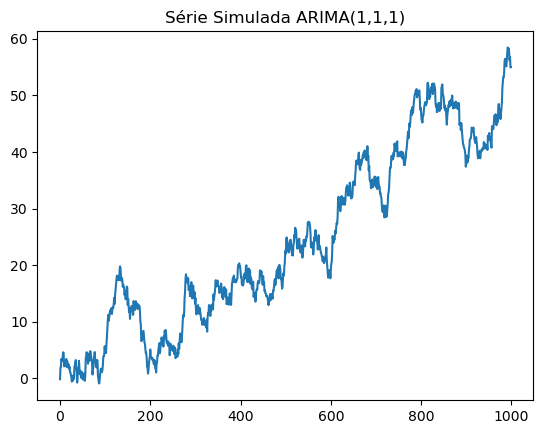

In [3]:
np.random.seed(99)
ar_params = np.array([1, -0.6])
ma_params = np.array([1, 0.5])
ar = np.r_[1, -ar_params[1:]]  # Adicionando 1 para a parte autorregressiva
ma = np.r_[1, ma_params[1:]]  # Adicionando 1 para a parte de médias móveis
arma_process = ArmaProcess(ar, ma)
x = arma_process.generate_sample(nsample=1000)
x = np.cumsum(x)  # Convertendo ARMA para ARIMA somando cumulativamente
plt.plot(x)
plt.title('Série Simulada ARIMA(1,1,1)')
plt.show()

## Teste de Estacionaridade

Antes de ajustar qualquer modelo, é importante verificar se a série é estacionária.

### Teste KPSS

O **Teste KPSS** verifica se uma série temporal é estacionária ao redor de uma média constante (hipótese nula).

-   **Hipótese Nula (H0)**: A série é estacionária.
-   **Hipótese Alternativa (Ha)**: A série não é estacionária.

In [4]:
kpss_stat, p_value, lags, critical_values = kpss(x)
print('Teste KPSS:')
print(f'Estatística do teste: {kpss_stat:.4f}')
print(f'p-valor: {p_value:.4f}')
print('Valores Críticos:')
for key, value in critical_values.items():
    print(f'{key}: {value:.4f}')
print('Resultado:')
if p_value > 0.05:
    print("Falha ao rejeitar a hipótese nula: Os dados são estacionários.")
else:
    print("Rejeitamos a hipótese nula: Os dados não são estacionários.")



Teste KPSS:
Estatística do teste: 4.7530
p-valor: 0.0100
Valores Críticos:
10%: 0.3470
5%: 0.4630
2.5%: 0.5740
1%: 0.7390
Resultado:
Rejeitamos a hipótese nula: Os dados não são estacionários.


C:\Users\anail\AppData\Local\Temp\ipykernel_1708\1371150172.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, p_value, lags, critical_values = kpss(x)



Como a série é não estacionária, devemos transformá-la em uma série estacionária.

### Determinação do Número de Diferenciações Necessárias

A função `ndiffs` utiliza o teste KPSS para determinar quantas diferenciações são necessárias para tornar a série estacionária.

In [5]:
# Determinação do número de diferenciações necessárias
d = ndiffs(x, test='kpss')
print(f'Número de diferenciações necessárias: {d}')

Número de diferenciações necessárias: 1


### Aplicando as Diferenciações

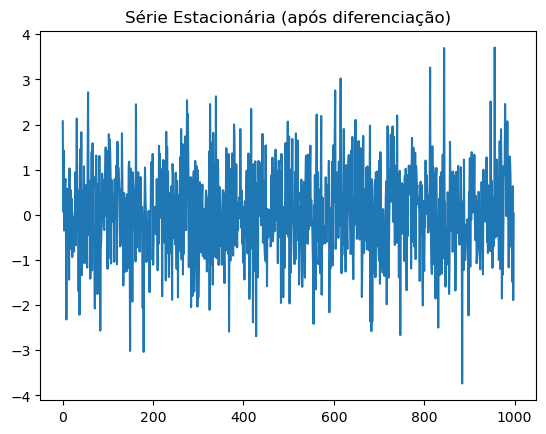

In [6]:
w = np.diff(x, n=d)
plt.plot(w)
plt.title('Série Estacionária (após diferenciação)')
plt.show()

## Análise da Série Estacionária

Agora que temos uma série estacionária, podemos fazer os gráficos da ACF e PACF.

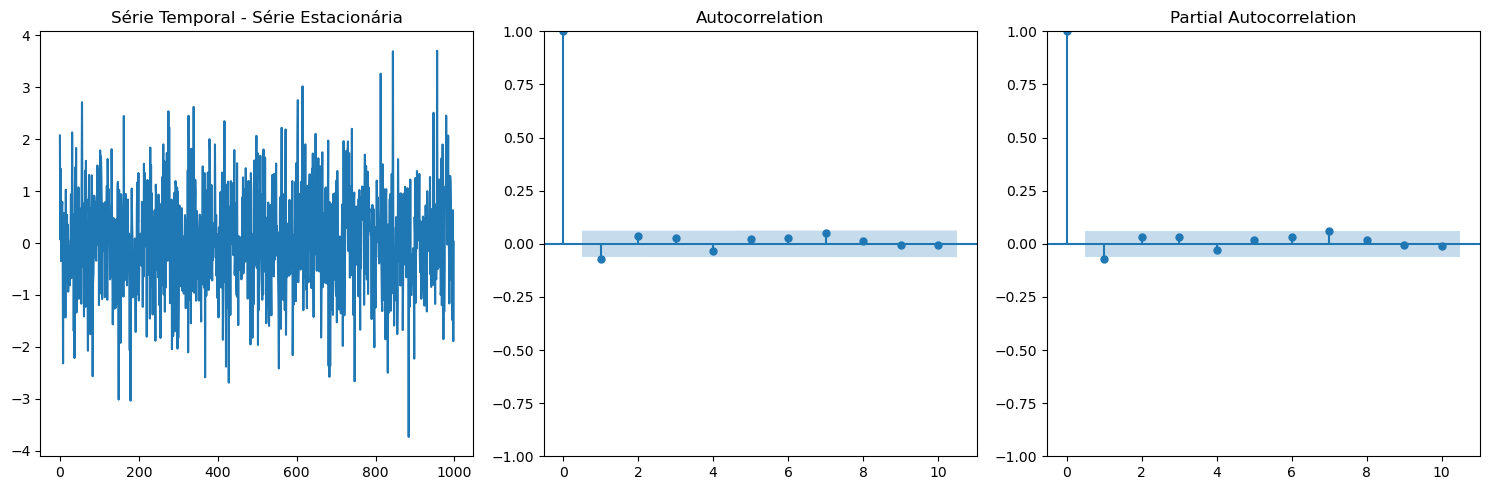

In [7]:
plot_acf_pacf(w, title='Série Estacionária')

A ACF demonstra um decaimento sem quebra, praticamente constante para zero. O PACF parece da mesma forma que a ACF, com decaimento constante, totalmente amortizado e sem quebras.

## Ajustando Modelos AR, MA e ARMA

### Verificando um Modelo AR

Supondo que olhamos para o gráfico e entendemos que por algum motivo o Modelo AR(4) seria adequado.

In [8]:
AR_model = ARIMA(w, order=(4, 0, 0)).fit()
E_AR = AR_model.resid

### Análise Gráfica dos Resíduos do Modelo AR

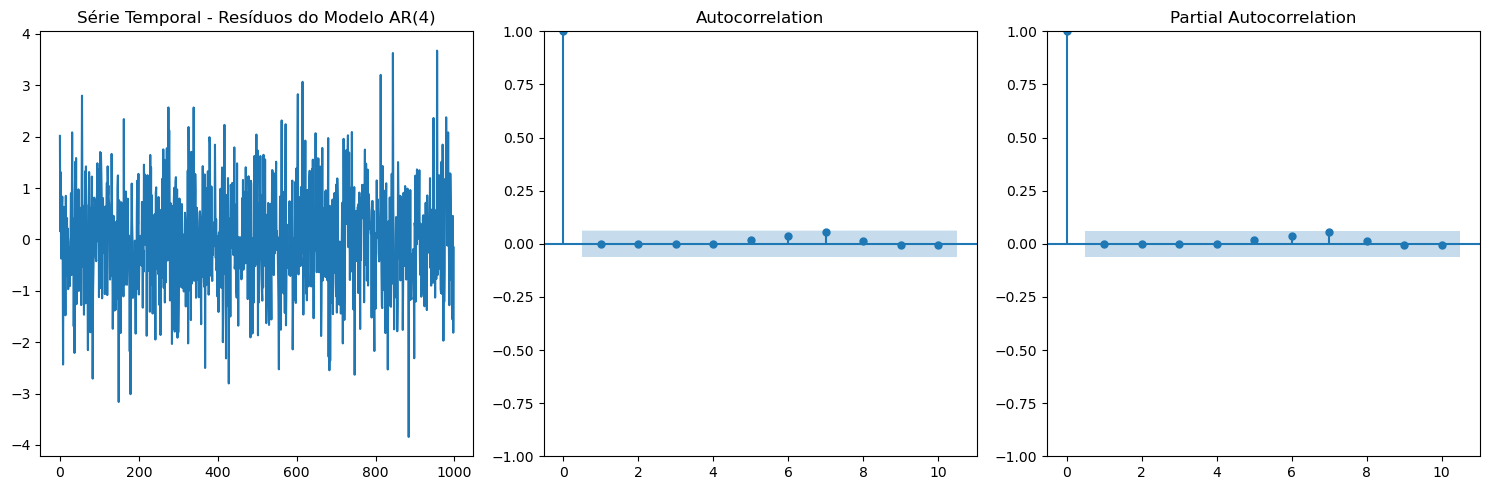

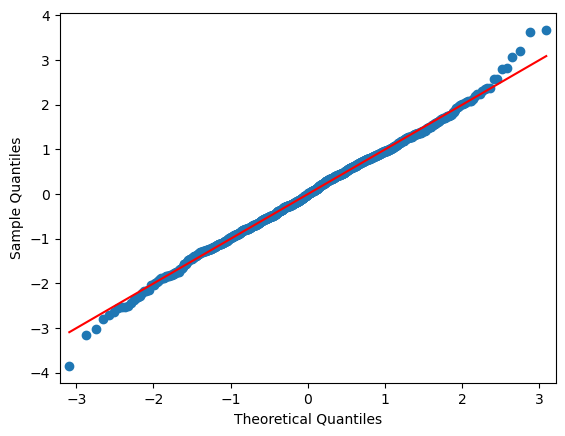

In [9]:
plot_acf_pacf(E_AR, title='Resíduos do Modelo AR(4)')
sm.qqplot(E_AR, line='s')
plt.show()


### Testes Estatísticos para Validar o Modelo AR

Temos que verificar se nossos resíduos são:

-   Normais

-   Independentes

-   Estacionários

### Teste de Estacionaridade

Antes de ajustar qualquer modelo, é importante verificar se a série é estacionária.

### Teste KPSS

O **Teste KPSS** verifica se uma série temporal é estacionária ao redor de uma média constante (hipótese nula).

-   **Hipótese Nula (H0)**: A série é estacionária.
-   **Hipótese Alternativa (Ha)**: A série não é estacionária.

In [10]:
# Teste de Estacionaridade - KPSS
kpss_stat, p_value, lags, critical_values = kpss(E_AR)
print('Teste KPSS para Resíduos do Modelo AR:')
print(f'Estatística do teste: {kpss_stat:.4f}')
print(f'p-valor: {p_value:.4f}')
for key, value in critical_values.items():
    print(f'{key}: {value:.4f}')



Teste KPSS para Resíduos do Modelo AR:
Estatística do teste: 0.0405
p-valor: 0.1000
10%: 0.3470
5%: 0.4630
2.5%: 0.5740
1%: 0.7390


C:\Users\anail\AppData\Local\Temp\ipykernel_1708\2215012712.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, critical_values = kpss(E_AR)


#### Teste de Independência - Ljung-Box

In [11]:
ljung_box_result = sm.stats.acorr_ljungbox(E_AR, lags=[20], return_df=True)
print('Teste de Independência - Ljung-Box:')
print(ljung_box_result)

Teste de Independência - Ljung-Box:
      lb_stat  lb_pvalue
20  15.740367   0.732595


#### Teste de Normalidade - Shapiro-Wilk

In [12]:
shapiro_stat, shapiro_p_value = shapiro(E_AR)
print('Teste de Normalidade - Shapiro-Wilk:')
print(f'Estatística do teste: {shapiro_stat:.4f}')
print(f'p-valor: {shapiro_p_value:.4f}')

Teste de Normalidade - Shapiro-Wilk:
Estatística do teste: 0.9975
p-valor: 0.1359


### Verificando um Modelo MA

Supondo que olhamos para o gráfico e entendemos que por algum motivo o Modelo MA(6) seria adequado.

In [13]:
# Verificando um Modelo MA(6)
MA_model = ARIMA(w, order=(0, 0, 6)).fit()
E_MA = MA_model.resid

### Análise Gráfica dos Resíduos do Modelo MA

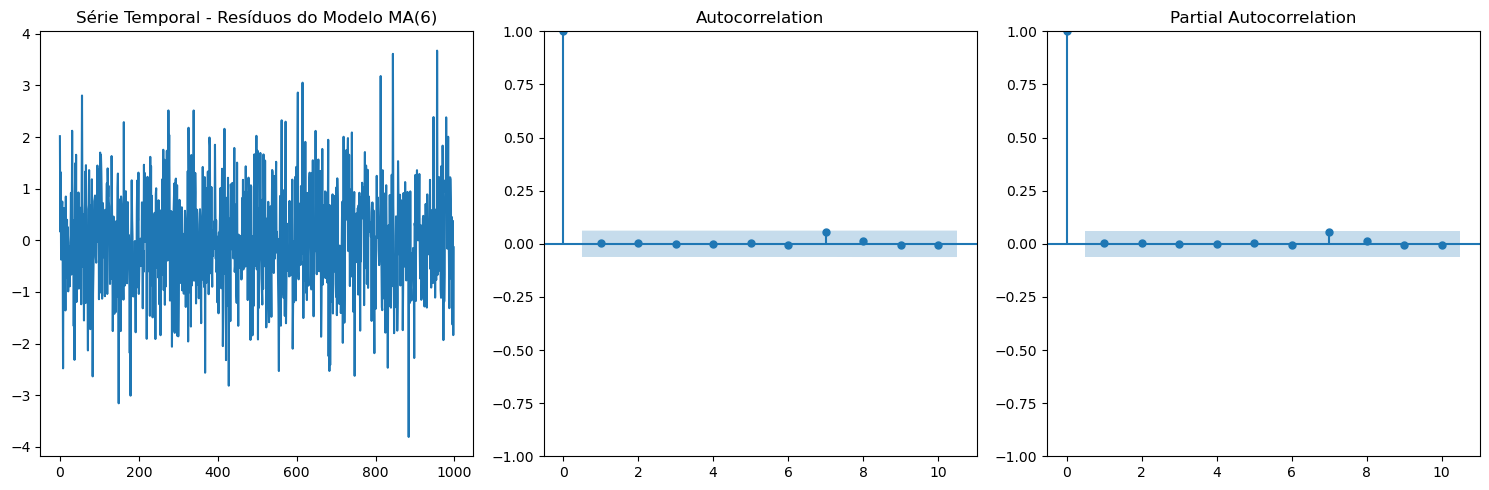

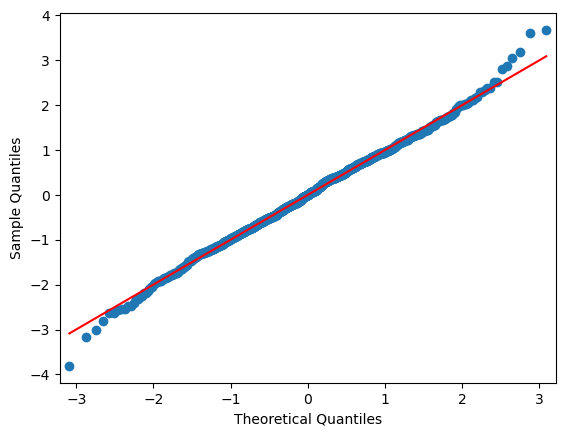

In [14]:
plot_acf_pacf(E_MA, title='Resíduos do Modelo MA(6)')
sm.qqplot(E_MA, line='s')
plt.show()

### Testes Estatísticos para Validar o Modelo MA

#### Teste de Estacionaridade - KPSS

O **Teste KPSS** verifica se uma série temporal é estacionária ao redor de uma média constante (hipótese nula).

-   **Hipótese Nula (H0)**: A série é estacionária.
-   **Hipótese Alternativa (Ha)**: A série não é estacionária.

In [15]:
# Teste de Estacionaridade - KPSS
kpss_stat, p_value, lags, critical_values = kpss(E_MA)
print('Teste KPSS para Resíduos do Modelo MA:')
print(f'Estatística do teste: {kpss_stat:.4f}')
print(f'p-valor: {p_value:.4f}')
for key, value in critical_values.items():
    print(f'{key}: {value:.4f}')

Teste KPSS para Resíduos do Modelo MA:
Estatística do teste: 0.0361
p-valor: 0.1000
10%: 0.3470
5%: 0.4630
2.5%: 0.5740
1%: 0.7390


C:\Users\anail\AppData\Local\Temp\ipykernel_1708\26531718.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, critical_values = kpss(E_MA)


#### Teste de Independência - Ljung-Box

In [16]:
ljung_box_result = sm.stats.acorr_ljungbox(E_MA, lags=[20], return_df=True)
print('Teste de Independência - Ljung-Box:')
print(ljung_box_result)

Teste de Independência - Ljung-Box:
      lb_stat  lb_pvalue
20  13.788573   0.841052


#### Teste de Normalidade - Shapiro-Wilk

In [17]:
shapiro_stat, shapiro_p_value = shapiro(E_MA)
print('Teste de Normalidade - Shapiro-Wilk:')
print(f'Estatística do teste: {shapiro_stat:.4f}')
print(f'p-valor: {shapiro_p_value:.4f}')

Teste de Normalidade - Shapiro-Wilk:
Estatística do teste: 0.9976
p-valor: 0.1517


### Verificando um Modelo ARMA

Supondo que olhamos para o gráfico e entendemos que por algum motivo o Modelo ARMA(1,1) seria adequado.

In [18]:
ARMA_model = ARIMA(w, order=(1, 0, 1)).fit()
E_ARMA = ARMA_model.resid

### Análise Gráfica dos Resíduos do Modelo ARMA

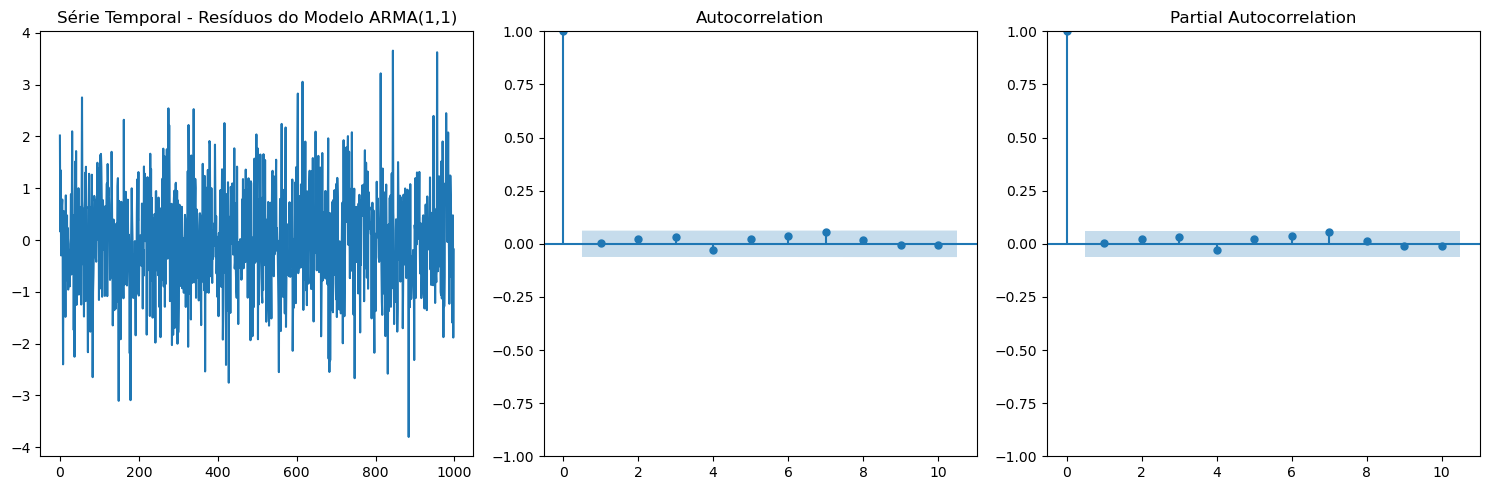

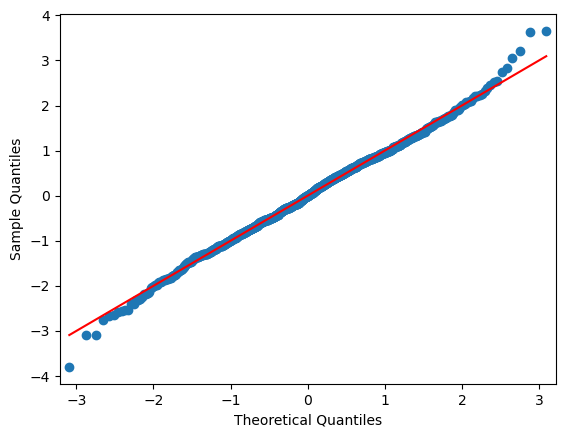

In [19]:
plot_acf_pacf(E_ARMA, title='Resíduos do Modelo ARMA(1,1)')
sm.qqplot(E_ARMA, line='s')
plt.show()

### Testes Estatísticos para Validar o Modelo ARMA

#### Teste de Estacionaridade - KPSS


O **Teste KPSS** verifica se uma série temporal é estacionária ao redor de uma média constante (hipótese nula).

-   **Hipótese Nula (H0)**: A série é estacionária.
-   **Hipótese Alternativa (Ha)**: A série não é estacionária.

In [20]:
# Teste de Estacionaridade - KPSS
kpss_stat, p_value, lags, critical_values = kpss(E_ARMA)
print('Teste KPSS para Resíduos do Modelo ARMA:')
print(f'Estatística do teste: {kpss_stat:.4f}')
print(f'p-valor: {p_value:.4f}')
for key, value in critical_values.items():
    print(f'{key}: {value:.4f}')

Teste KPSS para Resíduos do Modelo ARMA:
Estatística do teste: 0.0425
p-valor: 0.1000
10%: 0.3470
5%: 0.4630
2.5%: 0.5740
1%: 0.7390


C:\Users\anail\AppData\Local\Temp\ipykernel_1708\2853225184.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, critical_values = kpss(E_ARMA)


#### Teste de Independência - Ljung-Box

In [21]:
ljung_box_result = sm.stats.acorr_ljungbox(E_ARMA, lags=[20], return_df=True)
print('Teste de Independência - Ljung-Box:')
print(ljung_box_result)

Teste de Independência - Ljung-Box:
      lb_stat  lb_pvalue
20  17.785525   0.601534


#### Teste de Normalidade - Shapiro-Wilk

In [22]:
shapiro_stat, shapiro_p_value = shapiro(E_ARMA)
print('Teste de Normalidade - Shapiro-Wilk:')
print(f'Estatística do teste: {shapiro_stat:.4f}')
print(f'p-valor: {shapiro_p_value:.4f}')

Teste de Normalidade - Shapiro-Wilk:
Estatística do teste: 0.9975
p-valor: 0.1344


### Comparação de Modelos

Modelo AR(4)

In [23]:
print("\nModelo AR(4):")
print(AR_model.summary())


Modelo AR(4):
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  999
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -1417.435
Date:                Thu, 04 Jul 2024   AIC                           2846.870
Time:                        21:34:00   BIC                           2876.310
Sample:                             0   HQIC                          2858.060
                                - 999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0551      0.031      1.783      0.075      -0.005       0.116
ar.L1         -0.0693      0.035     -1.961      0.050      -0.139   -3.22e-05
ar.L2          0.0361      0.032     

In [24]:
# MA(6)
print("\nModelo MA(6):")
print(MA_model.summary())


Modelo MA(6):
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  999
Model:                 ARIMA(0, 0, 6)   Log Likelihood               -1416.396
Date:                Thu, 04 Jul 2024   AIC                           2848.793
Time:                        21:34:46   BIC                           2888.047
Sample:                             0   HQIC                          2863.713
                                - 999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0551      0.033      1.690      0.091      -0.009       0.119
ma.L1         -0.0742      0.035     -2.092      0.036      -0.144      -0.005
ma.L2          0.0384      0.032     

In [25]:
# ARMA(1,1)
print("\nModelo ARMA(1,1):")
print(ARMA_model.summary())


Modelo ARMA(1,1):
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  999
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1418.661
Date:                Thu, 04 Jul 2024   AIC                           2845.323
Time:                        21:35:31   BIC                           2864.950
Sample:                             0   HQIC                          2852.783
                                - 999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0550      0.030      1.831      0.067      -0.004       0.114
ar.L1         -0.2736      0.400     -0.684      0.494      -1.058       0.510
ma.L1          0.2011      0.410 

In [28]:
# Geração Automática da Ordem do Modelo de Séries Temporais
from pmdarima import auto_arima

auto_model = auto_arima(x, seasonal=False, stepwise=True)
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1418.918
Date:                Thu, 04 Jul 2024   AIC                           2843.836
Time:                        21:39:19   BIC                           2858.556
Sample:                             0   HQIC                          2849.431
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0590      0.032      1.836      0.066      -0.004       0.122
ar.L1         -0.0717      0.035     -2.054      0.040      -0.140      -0.003
sigma2         1.0028      0.042     24.140      0.0